In [42]:
#import necessary libraries
import shap
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from evolutionary_algorithm import EvolutionaryAlgorithm

In [30]:
# Define the EvolutionaryAlgorithm class

class EvolutionaryAlgorithm:
    def __init__(self, data):
        self.data = data
        # Clean numeric columns by removing commas and converting to float
        for column in self.data.columns:
            try:
                self.data[column] = self.data[column].str.replace(',', '').astype(float)
            except (AttributeError, ValueError):
                continue
    
    # Define the objective function to calculate fitness 
    def objective_function(self, individual):
        try:
            co2_emissions = float(individual['Energy Related CO2missions (Gigatonnes)'])
            electricity_generation = float(individual['Electricity Generation (Terawatt-hours)'])
            fitness = -co2_emissions + 0.5 * electricity_generation
            return fitness
        except (ValueError, KeyError) as e:
            print(f"Error in objective function: {e}")
            print(f"Individual data: {individual}")
            return float('-inf')  # Return worst possible fitness if there's an error
    
    # Initialize the population by randomly sampling from the dataset
    def initialize_population(self, population_size):
        population = []
        for _ in range(population_size):
            individual = self.data.sample().squeeze().to_dict()  # Convert to dictionary for easier handling
            population.append(individual)
        return population
    
    # Select the top half of the population based on fitness scores
    def selection(self, population, fitness_scores):
        population_fitness = list(zip(fitness_scores, population))
        population_fitness.sort(reverse=True, key=lambda x: x[0])
        selected = [ind for score, ind in population_fitness[:len(population)//2]]
        return selected
    
    # Perform crossover by mixing features from two parents
    def crossover(self, parent1, parent2):
        child = {}
        for key in parent1.keys():
            if random.random() < 0.5:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        return child

    #  Mutate an individual's features slightly to introduce variation
    def mutate(self, individual, mutation_rate):
        mutated = individual.copy()
        for key in mutated.keys():
            if random.random() < mutation_rate:
                try:
                    min_val = float(self.data[key].min())
                    max_val = float(self.data[key].max())
                    mutated[key] = random.uniform(min_val, max_val)
                except (ValueError, TypeError):
                    continue
        return mutated
    
    # Main function to run the evolutionary algorithm
    def run(self):
        population_size = 50
        generations = 100
        mutation_rate = 0.1

        # Initialize population
        population = self.initialize_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []

        for generation in range(generations):
            # Evaluate fitness
            fitness_scores = [self.objective_function(individual) for individual in population]
            
            # Track statistics
            best_fitness = max(fitness_scores)
            avg_fitness = sum(fitness_scores) / len(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            print(f"Generation {generation + 1}")
            print(f"Best Fitness: {best_fitness:.2f}")
            print(f"Average Fitness: {avg_fitness:.2f}")
            print("-" * 40)

            # Selection
            selected_population = self.selection(population, fitness_scores)

            # Crossover and mutation
            new_population = []
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(selected_population, 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child, mutation_rate)
                new_population.append(child)

            population = new_population
        
        # Store the final population for analysis
        self.final_population = population 
        
        print("\nEvolution complete!")
        print(f"Final Best Fitness: {max(fitness_scores):.2f}")
        return best_fitness_history, avg_fitness_history


In [31]:
# Load the final cleaned dataset
final_merged_df = pd.read_csv('scaled_merged_dataset.csv') 

In [32]:
# Initialize the evolutionary algorithm with the data
ea = EvolutionaryAlgorithm(data=final_merged_df)

In [33]:
# Run the evolutionary algorithm
best_fitness_history, avg_fitness_history = ea.run()

Generation 1
Best Fitness: 12810.75
Average Fitness: 10078.07
----------------------------------------
Generation 2
Best Fitness: 12811.85
Average Fitness: 11362.53
----------------------------------------
Generation 3
Best Fitness: 12813.03
Average Fitness: 12069.55
----------------------------------------
Generation 4
Best Fitness: 12813.24
Average Fitness: 12301.06
----------------------------------------
Generation 5
Best Fitness: 12812.89
Average Fitness: 12107.31
----------------------------------------
Generation 6
Best Fitness: 12813.50
Average Fitness: 12428.32
----------------------------------------
Generation 7
Best Fitness: 12813.50
Average Fitness: 12726.67
----------------------------------------
Generation 8
Best Fitness: 12813.50
Average Fitness: 12535.59
----------------------------------------
Generation 9
Best Fitness: 12813.50
Average Fitness: 12491.10
----------------------------------------
Generation 10
Best Fitness: 12813.50
Average Fitness: 12615.74
----------

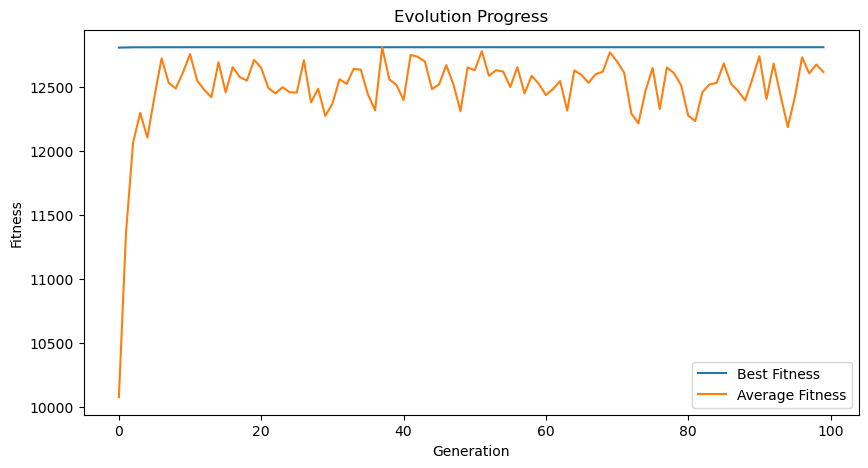

In [34]:
# Visualize the evolutionary process
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_history, label='Best Fitness')
plt.plot(avg_fitness_history, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution Progress')
plt.legend()
plt.show()

Calculating SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]


Generating SHAP summary plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_56063/1898009124.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


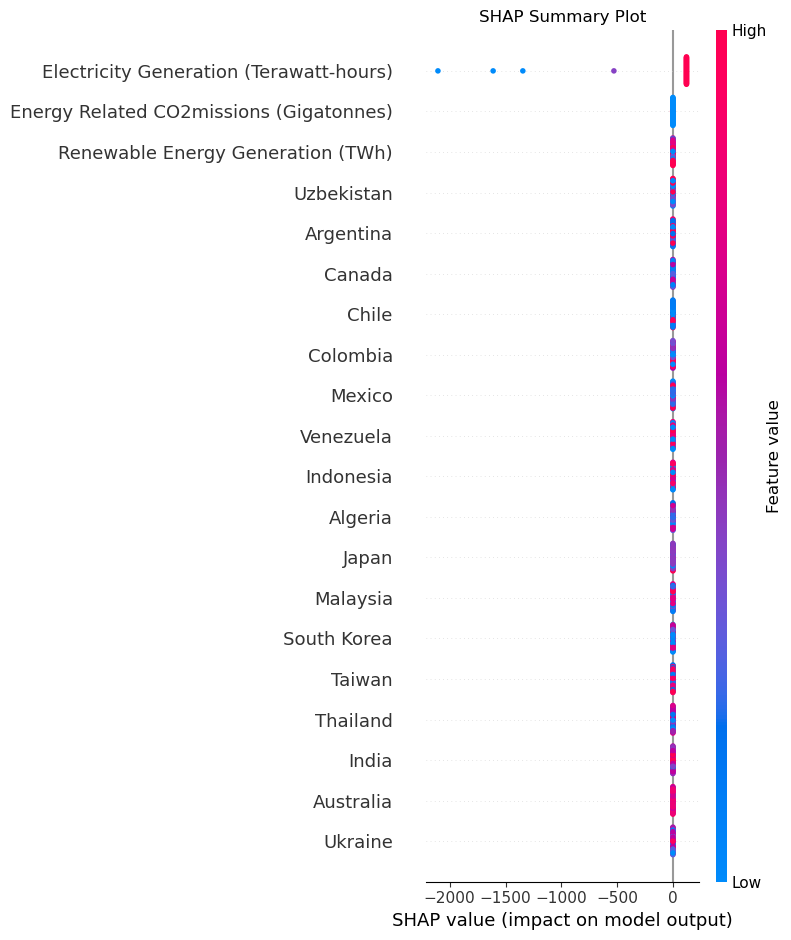


Generating feature importance plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_56063/1898009124.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


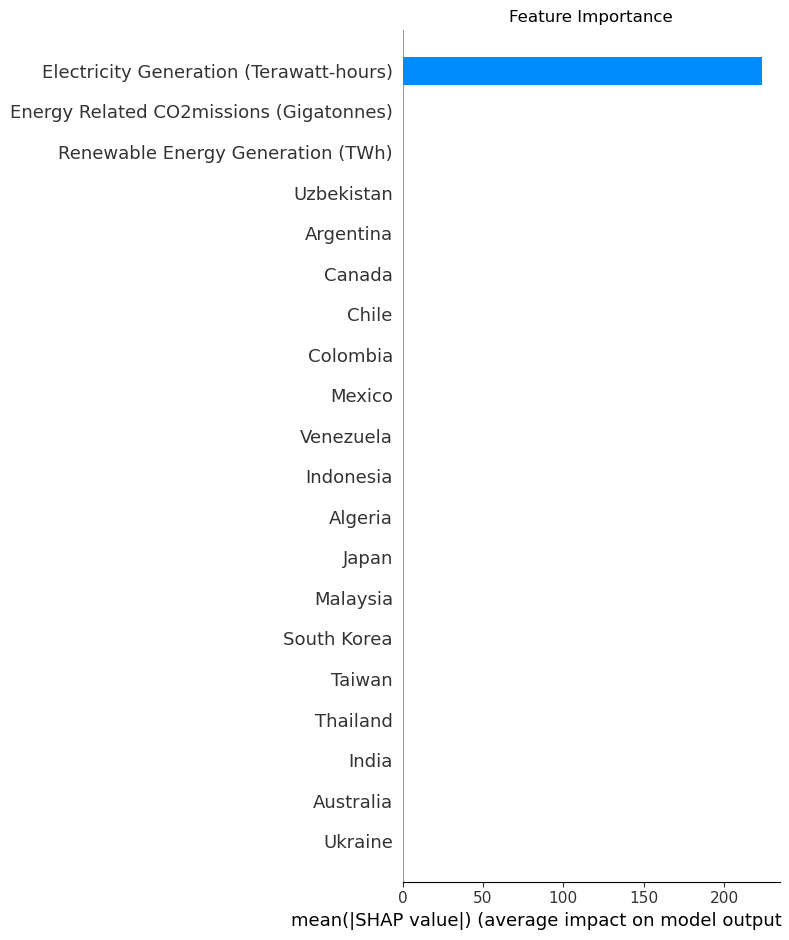


Top 5 Most Important Features:
                                    Feature  Importance
49  Electricity Generation (Terawatt-hours)  223.594288
45  Energy Related CO2missions (Gigatonnes)    0.194136
50      Hydroelectricity consumption in TWh    0.000000
57                         Geothermal (TWh)    0.000000
56                           Solar PV (TWh)    0.000000


In [27]:
# SHAP integration to analyze final population
def analyze_final_population(ea):
    final_population_df = pd.DataFrame(ea.final_population)
    for col in final_population_df.columns:
        try:
            final_population_df[col] = pd.to_numeric(final_population_df[col], errors='coerce')
        except:
            continue
            
    # Drop any non-numeric columns
    numeric_cols = final_population_df.select_dtypes(include=[np.number]).columns
    final_population_df = final_population_df[numeric_cols]
    
    # Create a wrapper for the fitness function that works with numpy arrays
    def fitness_model(X):
        results = []
        for i in range(len(X)):
            individual = {col: X[i, j] for j, col in enumerate(numeric_cols)}
            results.append(ea.objective_function(individual))
        return np.array(results)
    
    # Create background data for SHAP
    background_data = final_population_df.sample(min(100, len(final_population_df)))
    
    # Initialize SHAP explainer
    explainer = shap.KernelExplainer(fitness_model, background_data)
    
    # Calculate SHAP values for a subset of the final population
    sample_size = min(50, len(final_population_df)) 
    sample_data = final_population_df.sample(sample_size)

    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(sample_data)
    
    # Create summary plots
    print("\nGenerating SHAP summary plot...")
    shap.summary_plot(shap_values, sample_data, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()
    
    # Create feature importance plot
    print("\nGenerating feature importance plot...")
    shap.summary_plot(shap_values, sample_data, plot_type="bar", show=False)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Return the SHAP values and processed data for further analysis if needed
    return shap_values, sample_data

# Run SHAP analysis on the final population
shap_values, analyzed_data = analyze_final_population(ea)

# Print top 5 most important features based on mean absolute SHAP values
feature_importance = pd.DataFrame({
    'Feature': analyzed_data.columns,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

In [37]:
# Improved Evolutionary Algorithm
class EvolutionaryAlgorithm:
    def __init__(self, data):
        self.data = data
        for column in self.data.columns:
            try:
                self.data[column] = self.data[column].str.replace(',', '').astype(float)
            except (AttributeError, ValueError):
                continue

    def objective_function(self, individual):
        try:
            # Core metrics
            co2_emissions = float(individual['Energy Related CO2missions (Gigatonnes)'])
            electricity_generation = float(individual['Electricity Generation (Terawatt-hours)'])
            
            # Renewable energy components
            hydro = float(individual.get('Hydroelectricity consumption in TWh', 0))
            solar = float(individual.get('Solar PV (TWh)', 0))
            geothermal = float(individual.get('Geothermal (TWh)', 0))
            
            # Calculate total renewable energy
            total_renewables = hydro + solar + geothermal
            
            # Calculate renewable percentage
            renewable_percentage = (total_renewables / electricity_generation) if electricity_generation > 0 else 0
            
            # Enhanced fitness function considering multiple factors
            fitness = (
                -2.0 * co2_emissions +  # Heavily penalize CO2 emissions
                0.5 * electricity_generation +  # Reward total generation
                1.0 * total_renewables +  # Reward renewable energy
                2.0 * renewable_percentage  # Extra reward for higher renewable percentage
            )
            
            return fitness
        except (ValueError, KeyError):
            return float('-inf')
        
    def initialize_population(self, population_size):
        population = []
        for _ in range(population_size):
            individual = self.data.sample().squeeze().to_dict()
            population.append(individual)
        return population

    def selection(self, population, fitness_scores):
        population_fitness = list(zip(fitness_scores, population))
        population_fitness.sort(reverse=True, key=lambda x: x[0])
        selected = [ind for score, ind in population_fitness[:len(population)//2]]
        return selected

    def crossover(self, parent1, parent2):
        child = {}
        for key in parent1.keys():
            child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
        return child

    def mutate(self, individual, mutation_rate):
        mutated = individual.copy()
        for key in mutated.keys():
            if random.random() < mutation_rate:
                try:
                    min_val = float(self.data[key].min())
                    max_val = float(self.data[key].max())
                    mutated[key] = random.uniform(min_val, max_val)
                except (ValueError, TypeError):
                    continue
        return mutated
    
    #  Slightly tweak the individual’s features to see if we can improve fitness.
    def local_search(self, individual):
        improved_individual = individual.copy()
        mutation_rate = 0.02  # Small rate for local search tweaking
        return self.mutate(improved_individual, mutation_rate)

    def run(self, population_size=50, generations=100, mutation_rate=0.1, apply_local_search_every=10):
        population = self.initialize_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []

        for generation in range(generations):
            fitness_scores = [self.objective_function(individual) for individual in population]
            
            best_fitness = max(fitness_scores)
            avg_fitness = sum(fitness_scores) / len(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            print(f"Generation {generation + 1}")
            print(f"Best Fitness: {best_fitness:.2f}")
            print(f"Average Fitness: {avg_fitness:.2f}")
            print("-" * 40)

            selected_population = self.selection(population, fitness_scores)

            new_population = []
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(selected_population, 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child, mutation_rate)
                new_population.append(child)

            # Apply local search every few generations
            if (generation + 1) % apply_local_search_every == 0:
                print(f"Applying local search at generation {generation + 1}")
                best_individuals = selected_population[:len(selected_population)//4]  # Top 25%
                for i in range(len(best_individuals)):
                    best_individuals[i] = self.local_search(best_individuals[i])
                
                new_population.extend(best_individuals[:population_size - len(new_population)])  # Add them to new population

            population = new_population

        self.final_population = population

        print("\nEvolution complete!")
        print(f"Final Best Fitness: {max(fitness_scores):.2f}")
        return best_fitness_history, avg_fitness_history

Generation 1
Best Fitness: 12815.70
Average Fitness: 10358.13
----------------------------------------
Generation 2
Best Fitness: 12818.94
Average Fitness: 11688.74
----------------------------------------
Generation 3
Best Fitness: 12818.94
Average Fitness: 12217.13
----------------------------------------
Generation 4
Best Fitness: 12815.13
Average Fitness: 12282.33
----------------------------------------
Generation 5
Best Fitness: 12817.43
Average Fitness: 12446.74
----------------------------------------
Generation 6
Best Fitness: 12818.14
Average Fitness: 12525.27
----------------------------------------
Generation 7
Best Fitness: 12818.02
Average Fitness: 12271.63
----------------------------------------
Generation 8
Best Fitness: 12819.09
Average Fitness: 12545.67
----------------------------------------
Generation 9
Best Fitness: 12819.98
Average Fitness: 12677.23
----------------------------------------
Generation 10
Best Fitness: 12819.77
Average Fitness: 12518.65
----------

  0%|          | 0/50 [00:00<?, ?it/s]


Generating SHAP summary plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_56063/1898009124.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


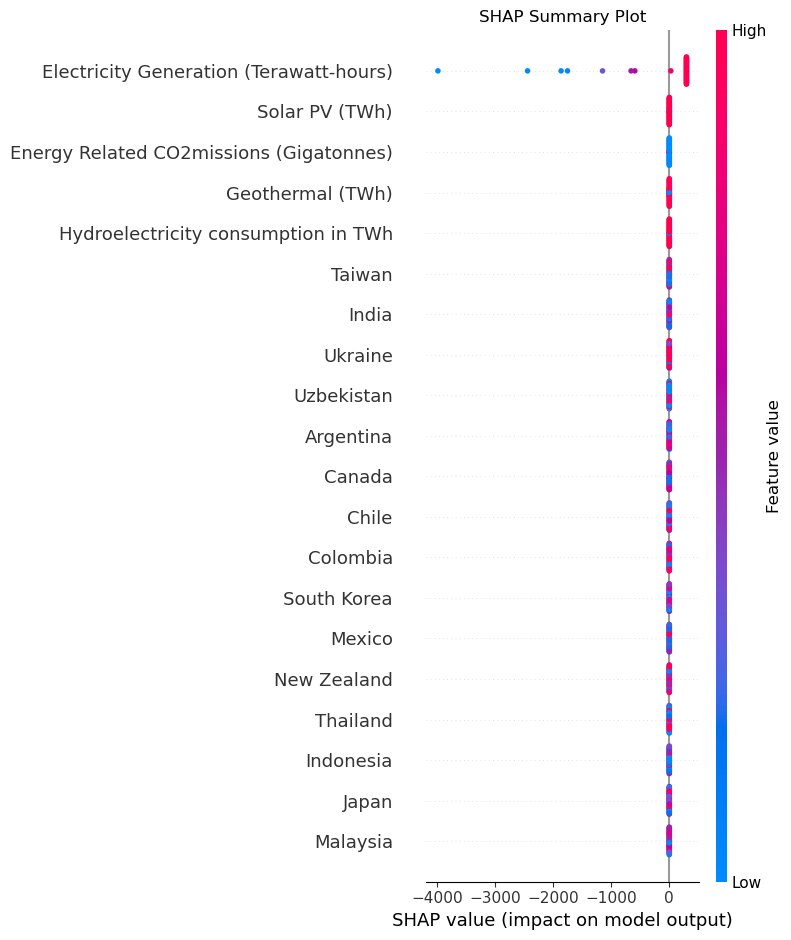


Generating feature importance plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_56063/1898009124.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


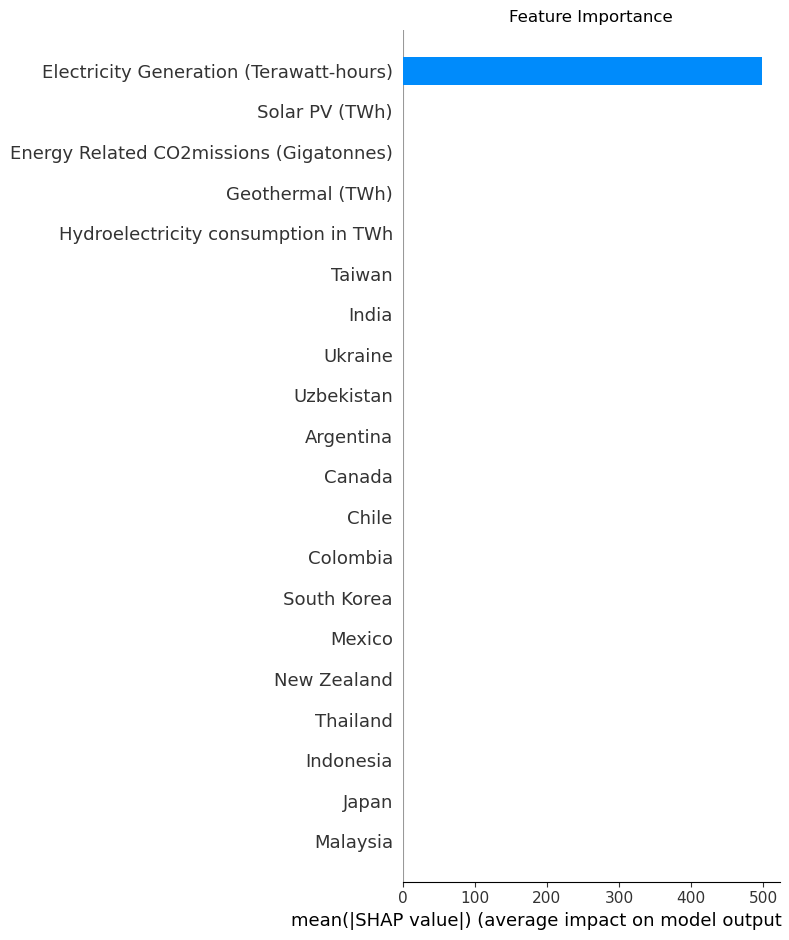

In [38]:
# Initialize with new objective function
ea_improved = EvolutionaryAlgorithm(data=final_merged_df)

# Run evolution
best_fitness_history, avg_fitness_history = ea_improved.run(
    population_size=50,
    generations=100,
    mutation_rate=0.1,
    apply_local_search_every=10
)

# Run SHAP analysis again
shap_values, analyzed_data = analyze_final_population(ea_improved)

In [39]:
# Print top 5 most important features based on mean absolute SHAP values
feature_importance = pd.DataFrame({
    'Feature': analyzed_data.columns,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())


Top 5 Most Important Features:
                                    Feature  Importance
49  Electricity Generation (Terawatt-hours)  498.378570
56                           Solar PV (TWh)    0.449958
45  Energy Related CO2missions (Gigatonnes)    0.402508
57                         Geothermal (TWh)    0.333400
50      Hydroelectricity consumption in TWh    0.288706


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_56063/1172461928.py:7: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



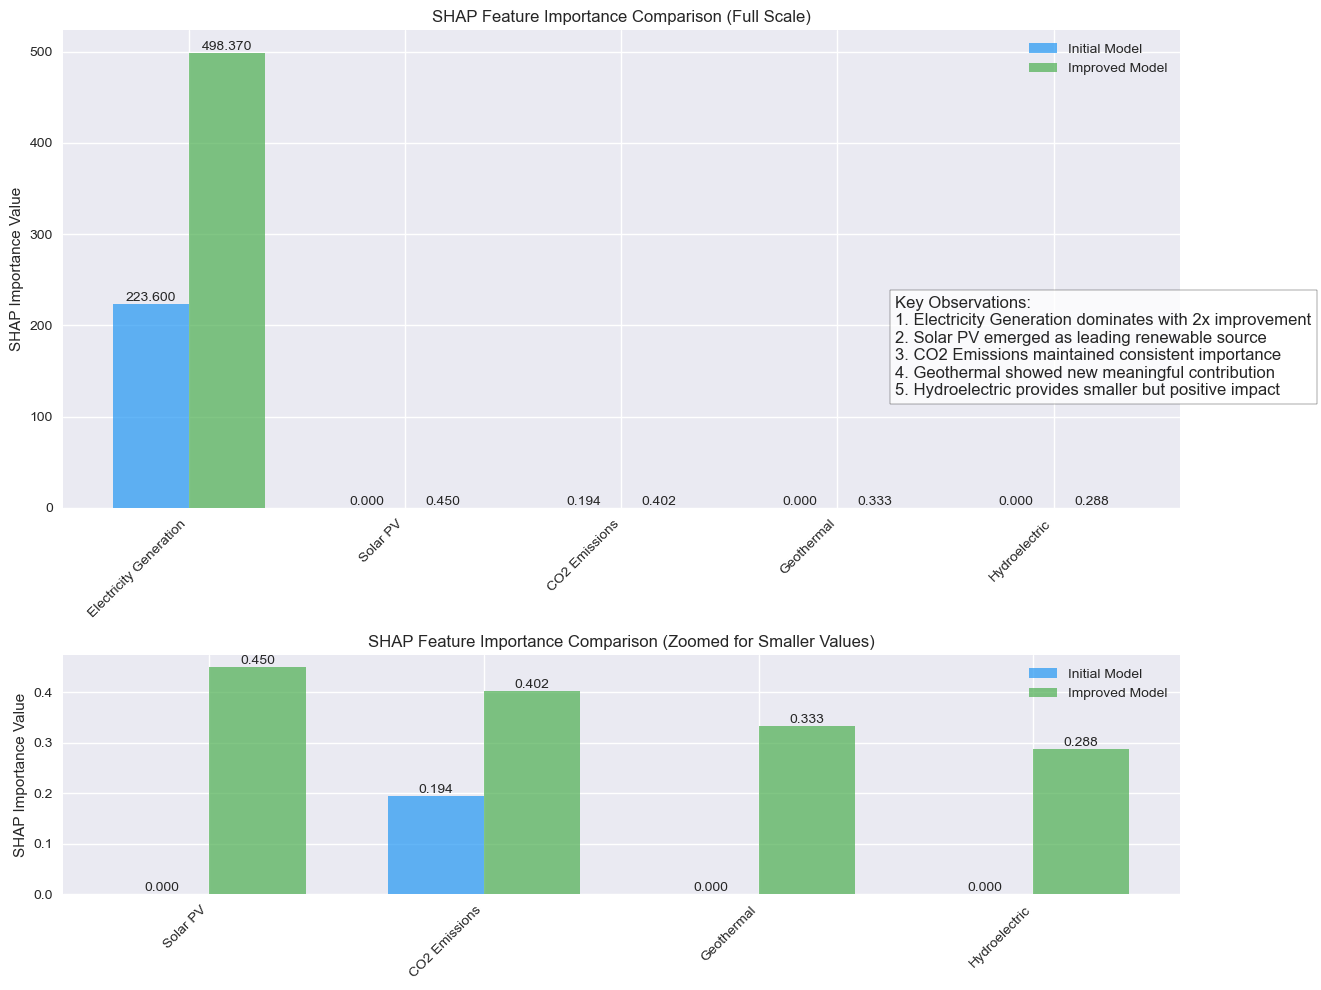

In [59]:
# Comparision of SHAP feature importance between Initial and Improved models with interactive bar plots.
features = ['Electricity Generation', 'Solar PV', 'CO2 Emissions', 'Geothermal', 'Hydroelectric']
initial_values = [223.6, 0, 0.194, 0, 0]
improved_values = [498.37, 0.450, 0.402, 0.333, 0.288]

# Set up the plot style
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Create color palette
colors = ['#4CAF50', '#2196F3']

# Main plot (full scale)
x = np.arange(len(features))
width = 0.35

ax1.bar(x - width/2, initial_values, width, label='Initial Model', color=colors[1], alpha=0.7)
ax1.bar(x + width/2, improved_values, width, label='Improved Model', color=colors[0], alpha=0.7)

ax1.set_ylabel('SHAP Importance Value')
ax1.set_title('SHAP Feature Importance Comparison (Full Scale)')
ax1.set_xticks(x)
ax1.set_xticklabels(features, rotation=45, ha='right')
ax1.legend()

# Add value labels on the bars
for i in range(len(features)):
    ax1.text(i - width/2, initial_values[i], f'{initial_values[i]:.3f}', 
             ha='center', va='bottom')
    ax1.text(i + width/2, improved_values[i], f'{improved_values[i]:.3f}', 
             ha='center', va='bottom')

# Secondary plot (zoomed in for smaller values)
# Exclude Electricity Generation for better visibility of smaller values
features_zoom = features[1:]
initial_values_zoom = initial_values[1:]
improved_values_zoom = improved_values[1:]

x_zoom = np.arange(len(features_zoom))

ax2.bar(x_zoom - width/2, initial_values_zoom, width, label='Initial Model', color=colors[1], alpha=0.7)
ax2.bar(x_zoom + width/2, improved_values_zoom, width, label='Improved Model', color=colors[0], alpha=0.7)

ax2.set_ylabel('SHAP Importance Value')
ax2.set_title('SHAP Feature Importance Comparison (Zoomed for Smaller Values)')
ax2.set_xticks(x_zoom)
ax2.set_xticklabels(features_zoom, rotation=45, ha='right')
ax2.legend()

# Add value labels on the zoomed bars
for i in range(len(features_zoom)):
    ax2.text(i - width/2, initial_values_zoom[i], f'{initial_values_zoom[i]:.3f}', 
             ha='center', va='bottom')
    ax2.text(i + width/2, improved_values_zoom[i], f'{improved_values_zoom[i]:.3f}', 
             ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()

# Add descriptions as text box
desc_text = (
    "Key Observations:\n"
    "1. Electricity Generation dominates with 2x improvement\n"
    "2. Solar PV emerged as leading renewable source\n"
    "3. CO2 Emissions maintained consistent importance\n"
    "4. Geothermal showed new meaningful contribution\n"
    "5. Hydroelectric provides smaller but positive impact"
)

fig.text(0.75, 0.6, desc_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Show plot
plt.show()